In [1]:
from vqvae import VQVAE
from utils import *


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.nn import functional as F

import numpy as np

# Visuals utils
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# 6. Visualize a Few Test Images and Their Predictions
def visualize_predictions(images):

    # Plot the images and predicted labels
    fig = plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = fig.add_subplot(3, 3, i+1)
        ax.imshow(images[i].numpy().squeeze(), cmap='gray')
        ax.axis('off')
    
    plt.show()


def evaluate_model(model, val_loader, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for (images, classes) in val_loader:
            inputs = images.float().to(device)
           
            outputs, _, _, _ = model(inputs)
            
            # Loss and backward
            loss = F.mse_loss(inputs, outputs)
            
            val_loss += loss.item()

    epoch_val_loss = val_loss / len(TestLoader.dataset)

    return epoch_val_loss

def plot_train_val_loss(train_loss_values, val_loss_values ):
    # Plot the training and validation losses
    plt.figure(figsize=(20, 10))
    plt.plot(train_loss_values, label='Train Loss')
    plt.plot(val_loss_values, label='Validation Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.title('Evolution of Loss')
    plt.legend()
    plt.grid()
    plt.show()


In [3]:

# detect gpu ?

print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


True
cuda:0


## Call the Fashin-mnist dataset

In [4]:

# 1. Load and Preprocess the Dataset
transform = transforms.Compose([
    transforms.ToTensor(),               # Convert images to PyTorch tensors
    # transforms.Normalize((0.5,), (0.5,)) # Normalize the images to [-1, 1]
])

# Download and load the Fashion-MNIST training and test dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

TrainLoader = DataLoader(train_dataset, batch_size=32, shuffle=True)
TestLoader  = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Class labels for reference
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']



## instanciate my VQ-VAE model 

In [5]:
K =  128 # size of the CodeBook
D =  32 # dimension of each embedding vector
in_channels = 1 # gray scale image  = 1 color channel
downsampling_factor = 4 # two stages of dwonsampling the image (28x28) --> (7x7) 

In [6]:
model = VQVAE(in_channels, D, K, downsampling_factor)

model = model.to(device)

In [18]:

### Learning parameters

lr = 5e-4
epochs = 20
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)


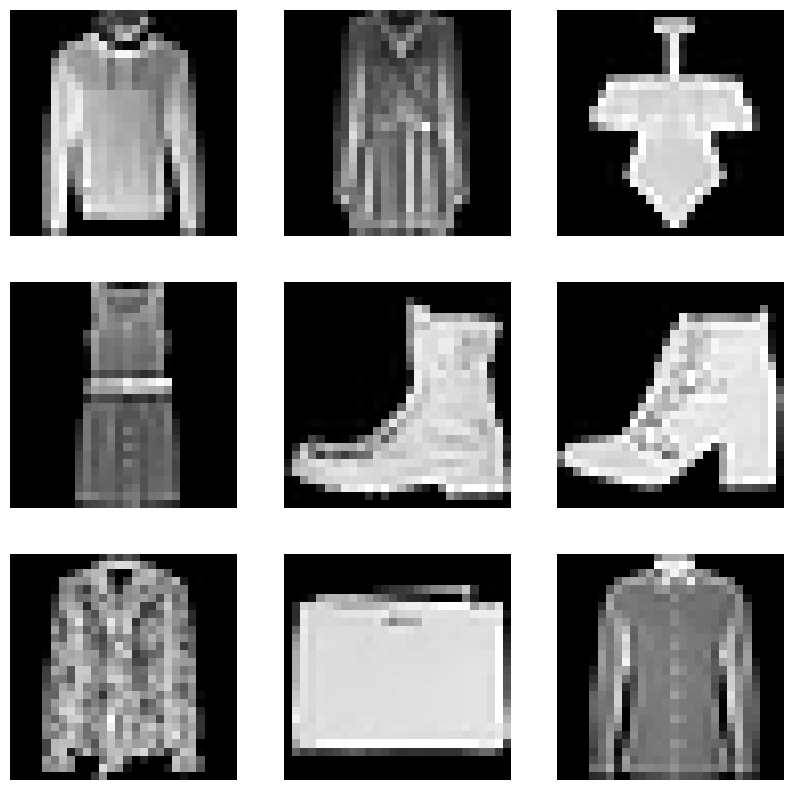

In [8]:
# visualisation batch, to track the performance of the model
vis_batch, classes = next(iter(TestLoader))

visualize_predictions(vis_batch)

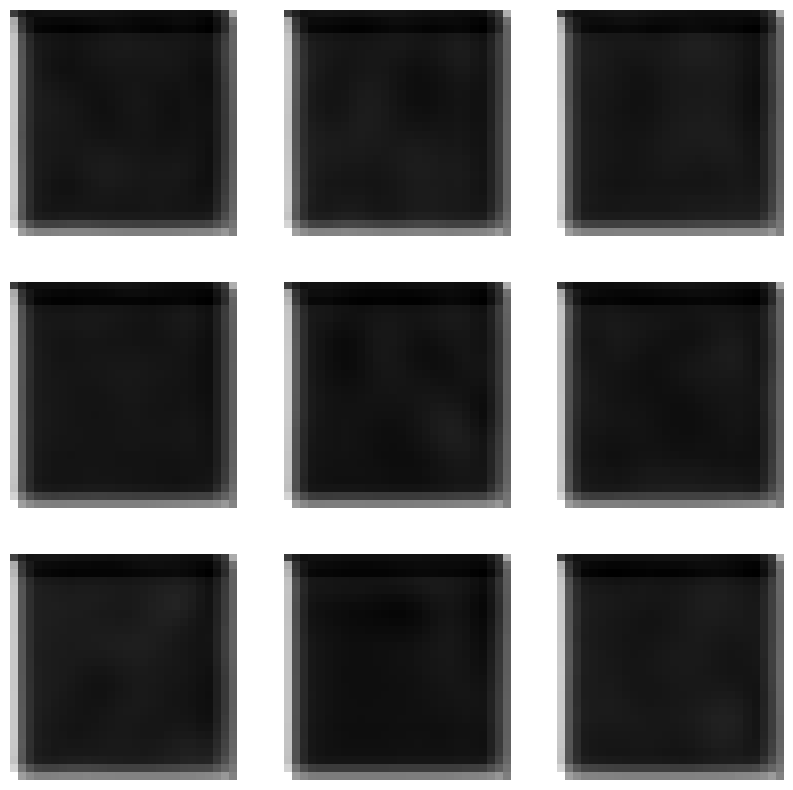

In [9]:
batch_hat = model.reconstruct(vis_batch.to(device)).cpu().detach()
visualize_predictions(batch_hat)

### observation
>> if the image above is null,  the model fails training fails to converge at all, i don"t understand this is due to what, run multiple times untill outputs are not all null.

---- 
### Training-Loop 

In [19]:
model.train()
train_loss_values = []
codebook_loss_values = []

#track the evolution of reconstruction
recons_evolution = []

val_loss_values = []
best_val_loss = float('inf')

for epoch in range(epochs):

    train_loss = 0.0
    codebook_loss_epoch = 0.0

    with tqdm(enumerate(TrainLoader), unit="batch", total=len(TrainLoader)) as tepoch:
        for batch_idx, (inputs, classes) in tepoch:
            inputs = inputs.float().to(device)  # Move data to the appropriate device (GPU/CPU)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass // args is a list containing : [output, input, vq_loss]
            output, inputs, codebook_loss, commit_loss = model(inputs)
            
            # Loss and backward
            loss = model.loss_function(output, inputs, codebook_loss, commit_loss)['loss']  # Use the loss function defined in the model
            loss.backward()
            optimizer.step()
            
            
            # Track running loss
            train_loss += loss.item()
            codebook_loss_epoch += codebook_loss.item()


            # tqdm bar displays the loss
            tepoch.set_postfix(loss=loss.item())

    epoch_loss = train_loss / len(TrainLoader.dataset)
    codebook_loss_epoch/= len(TrainLoader.dataset)

    train_loss_values.append(epoch_loss)
    codebook_loss_values.append(codebook_loss_epoch)

    # Validation after each epoch
    val_loss = evaluate_model(model, TestLoader, device)
    val_loss_values.append(val_loss)

    # #track output precision progression every 10 epoch:
    # if (epoch%5 == 0 and epoch<50):
    #     output, _, _, _ = model( vis_batch.float() )
    #     recons_evolution.append(output)

    print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(TrainLoader)))

print("Training complete.")

  0%|          | 0/1875 [00:00<?, ?batch/s]

100%|██████████| 1875/1875 [00:24<00:00, 75.22batch/s, loss=0.00886]


Epoch 0: Train Loss: 0.0091


100%|██████████| 1875/1875 [00:24<00:00, 77.80batch/s, loss=0.0104] 


Epoch 1: Train Loss: 0.0091


100%|██████████| 1875/1875 [00:23<00:00, 78.54batch/s, loss=0.00946]


Epoch 2: Train Loss: 0.0091


100%|██████████| 1875/1875 [00:24<00:00, 77.11batch/s, loss=0.00854]


Epoch 3: Train Loss: 0.0091


100%|██████████| 1875/1875 [00:25<00:00, 74.27batch/s, loss=0.0111] 


Epoch 4: Train Loss: 0.0091
Training complete.


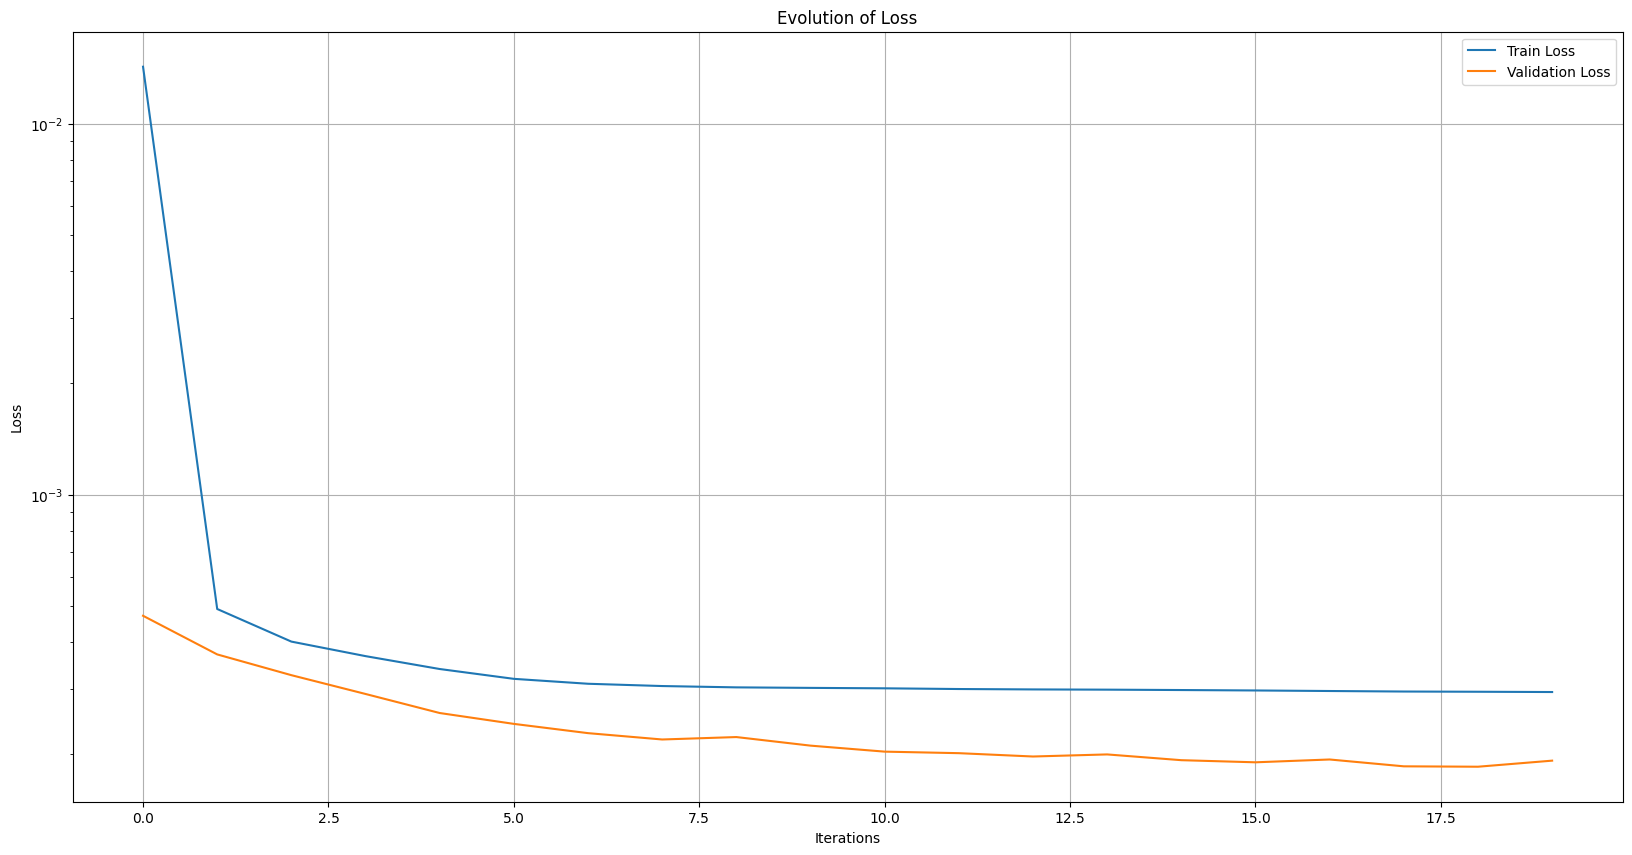

In [12]:
plot_train_val_loss(train_loss_values, val_loss_values)

In [20]:

save_path = "saved_models/model_101.pth"
save_model(save_path, model, epoch, train_loss_values, val_loss_values, codebook_loss_values)

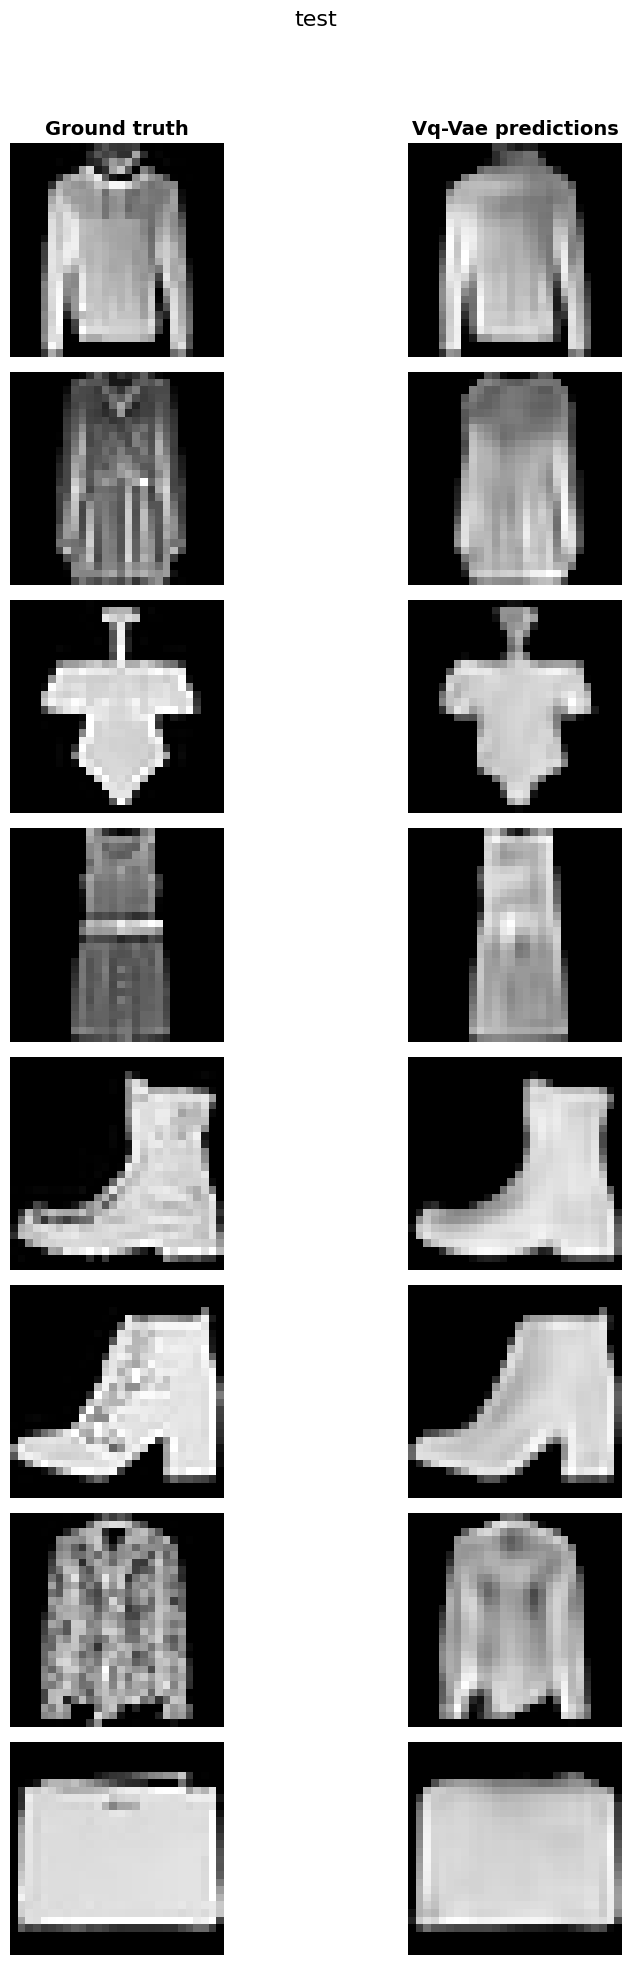

In [22]:
vis_batch.detach().cpu()
batch_hat,_,_,_ = model(vis_batch.to(device))
batch_hat = batch_hat.detach().cpu()

visualize_errors(vis_batch, batch_hat, 'test')

## Conclusion : 

>> We notice that the reconstruction aren't that bad, it fails to catch high frequencies information, this is may be due to the mse loss that tend to blurr the reconstructions, or due to the loss of informations in the botlle-neck of the VQ-VAE